

----------------------------------MFE-CONV1D-2C-----------------------------------------



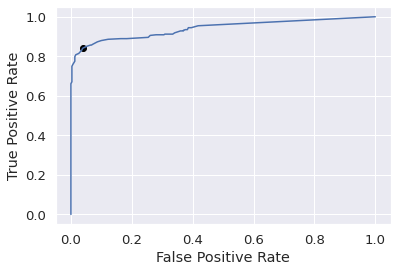

Best Threshold for ROC optimization=0.469000
AUC=0.9403102317835708


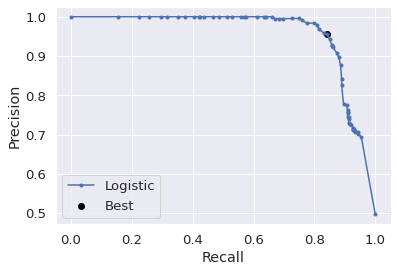

Best Threshold for PR optimization=0.469000, F-Score=0.89428

Brute-Force Threshold optimization=0.435, F-Score=0.89428




,Name,Inferencing Time,RAM Usage,ROM Usage,Inferences Done,Valid
0,MFE-CONV1D-2C,16ms,16.8Kb,75.2Kb,639,97.2%


Accuracy:  89.2(-0.2)
Recall:    83.9(0.8)
Precision: 95.9(0.0)
F1:        89.5(0.5)


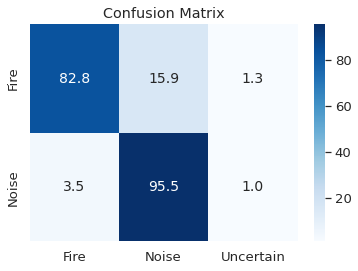

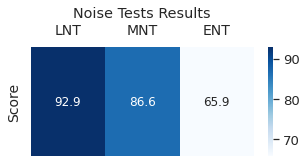


Max cons. fire while fire: 42(0.0) and avg. cons. 7.647(0.276)
Max cons. fire while noise: 2(0.0) and avg. cons. 1.1(0.0)


In [70]:
import sys
import os
import datetime
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.metrics import f1_score
from numpy import arange
from numpy import argmax
import seaborn as sn

class Frame:

    #hold start and end timestamp for each frame
    def __init__(self, startm, starts, endm, ends, type):

        self.start   = datetime.time(0,startm,starts)
        self.end     = datetime.time(0,endm,ends)
        self.type    = type

    def print(self):
        print("Sample type: " + self.type +" "+ str(self.start)+"-"+str(self.end))

class Inference:
    
    #hold start and end timestamp for each inference
    def __init__(self, startm, starts, endm, ends, type, confidence):

        self.start   = datetime.time(0,startm,starts)
        self.end     = datetime.time(0,endm,ends)
        self.type   = type

        if type == "F":
            self.Fconf = confidence
            self.Nconf = float("{:.3f}".format(1 - confidence))
        elif type == "N":
            self.Fconf = float("{:.3f}".format(1 - confidence))
            self.Nconf = confidence
        else:
            self.Fconf = 0
            self.Nconf = 0

    def print(self):
            print("Predicted: " + self.type +" "+ str(self.start)+"-"+str(self.end) + " Fire score: " + str(self.Fconf) + " Noise score: " + str(self.Nconf))

def avg(array):

    avg = 0.0
    for i in range (0, len(array),1):
        avg+=array[i]
    if len(array)!= 0:
        avg  = float("{:.3f}".format((float(avg/len(array)))))
    return avg

# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')

rexpected = []

# test's timestamps definition

frame = Frame(0,0,0,15,"Invalid")
rexpected.append(frame)
frame = Frame(0,16,2,15,"Noise") #birds
rexpected.append(frame)
frame = Frame(2,16,4,15,"LNT") #birds + LNT
rexpected.append(frame)
frame = Frame(4,16,6,15,"Noise") #crickets
rexpected.append(frame)
frame = Frame(6,16,8,15,"LNT") #crickets + LNT
rexpected.append(frame)
frame = Frame(8,16,10,15,"Noise") #rain
rexpected.append(frame)
frame = Frame(10,16,12,15,"Noise") #wind
rexpected.append(frame)
frame = Frame(12,16,14,15,"Noise") #birds
rexpected.append(frame)
frame = Frame(14,16,16,15,"LNT") #birds + LNT
rexpected.append(frame)
frame = Frame(16,16,18,15,"Noise") #insects
rexpected.append(frame)
frame = Frame(18,16,20,15,"LNT") #insects + LNT
rexpected.append(frame)
frame = Frame(20,16,22,15,"Noise") #rain
rexpected.append(frame)
frame = Frame(22,16,24,15,"Noise") #wind
rexpected.append(frame)
frame = Frame(24,16,26,15,"LNT") #Campfire
rexpected.append(frame)
frame = Frame(26,16,28,15,"MNT") #birds + MNT
rexpected.append(frame)
frame = Frame(28,16,30,15,"MNT") #birds + MNT
rexpected.append(frame)
frame = Frame(30,16,32,15,"Noise") #birds
rexpected.append(frame)
frame = Frame(32,16,34,15,"Noise") #insects
rexpected.append(frame)
frame = Frame(34,16,36,15,"LNT") #campfire
rexpected.append(frame)
frame = Frame(36,16,40,15,"Noise") #rain
rexpected.append(frame)
frame = Frame(40,16,44,15,"MNT") #insects + MNT
rexpected.append(frame)
frame = Frame(44,16,46,15,"Noise") #wind
rexpected.append(frame)
frame = Frame(46,16,48,15,"ENT") #birds + ENT
rexpected.append(frame)
frame = Frame(48,16,50,15,"ENT") #birds + ENT
rexpected.append(frame)
frame = Frame(50,16,54,15,"Noise") #rain
rexpected.append(frame)
frame = Frame(54,16,58,15,"ENT") #insects + ENT
rexpected.append(frame)
frame = Frame(58,16,59,59,"LNT") #Campfire
rexpected.append(frame)

#load test input from txt file
def load_input(file, treshold):

    input = open(file,"r")
    data = input.readlines()

    inferences = []

    for line in data:

        if line[0].isdigit():

            startmin = int(line[0:2])
            startsec = int(line[3:5])
            endmin   = int(line[6:8])
            endsec   = int(line[9:11])
            pred     = line[11]

            score    = float("{:.3f}".format(float(line[13:18])))
            if pred != "F" and score<(1-treshold):
                pred = "F"
                score = float("{:.3f}".format(1-treshold))
            elif (pred == "N" and score==(1-treshold)):
                pred  = "D"
                score = 0
            inf      = Inference(startmin, startsec, endmin, endsec, pred, score)
            inferences.append(inf)

        else:
            continue
    input.close()
    return inferences

#compute results from loaded inferences
def compute_results(data, plotting):

    frame_index=0
    noise_results = []
    fire_results  = []
    invalid = []
    uncertain = []
    max_consecutive_fire_while_fire = 0
    max_consecutive_fire_while_noise = 0
    consecutive_fire_while_fire = []
    consecutive_fire_while_noise = []
    last_consecutive_index = 0
    consec_fire = 0


    for count, inf in enumerate(inferences):

        if inf.start>=rexpected[frame_index].end:
            while inf.start>=rexpected[frame_index].start:
                if inf.start<rexpected[frame_index].end or (inf.end<=rexpected[frame_index].end and inf.start>=rexpected[frame_index].start):
                    break
                frame_index+=1
            consec_fire=1
            last_consecutive_index = count

        if (inf.start<rexpected[frame_index].end and inf.end>rexpected[frame_index].end) or rexpected[frame_index].type=="Invalid":
            tuple = ("Invalid", str(inf.start), str(inf.end))
            invalid.append(tuple)
        else:
            tuple = (rexpected[frame_index].type, inf.Fconf, inf.Nconf,str(inf.start),str(inf.end))
            #consectutive fire results algorithm
            if inf.type=="F":

                consec_fire = 1
                fire_results.append(tuple)

                if count>=last_consecutive_index:

                    for i in range(0, len(inferences)-count-1,1):

                        last_consecutive_index += 1

                        if inferences[count+i+1].type != "N" and inferences[count+i+1].start<rexpected[frame_index].end:
                            consec_fire += 1

                        if  inferences[count+i+1].type == "N" or inferences[count+i+1].start>rexpected[frame_index].end or last_consecutive_index >= len(inferences)-1:
                            if rexpected[frame_index].type == "ENT" or rexpected[frame_index].type == "MNT" or rexpected[frame_index].type == "LNT":
                                if consec_fire > max_consecutive_fire_while_fire:
                                    max_consecutive_fire_while_fire=consec_fire
                                consecutive_fire_while_fire.append(consec_fire)
                            elif rexpected[frame_index].type == "Noise":
                                if consec_fire > max_consecutive_fire_while_noise:
                                    max_consecutive_fire_while_noise=consec_fire
                                consecutive_fire_while_noise.append(consec_fire)
                            break



            elif inf.type=="N":
                noise_results.append(tuple)
                last_consecutive_index += 1
            elif inf.type=="D":
                uncertain.append(tuple)
                last_consecutive_index += 1
            if count == len(inferences)-1 and inferences[-1].type == "F" and inferences[-2].type != "F" and rexpected[frame_index].type != "Noise":
                consecutive_fire_while_fire.append(1)
            elif count == len(inferences)-1 and inferences[-1].type == "F" and inferences[-2].type != "F" and rexpected[frame_index].type == "Noise":
                consecutive_fire_while_noise.append(1)

    #calculate test statistics

    inf_while_fire  = 0
    inf_while_noise = 0
    inf_while_ENT  = 0
    inf_while_MNT  = 0
    inf_while_LNT  = 0

    noise_while_ENT = 0

    uncertain_while_fire  = 0
    uncertain_while_noise = 0

    avg_fire_while_fire    = []
    avg_noise_while_noise  = []

    avg_fire_while_LNT   = []
    avg_fire_while_MNT   = []
    avg_fire_while_ENT   = []

    avg_noise_while_fire   = []
    avg_fire_while_noise   = []


    for i in range(0,len(fire_results),1):

        if fire_results[i][0] == "ENT" or fire_results[i][0] == "MNT" or fire_results[i][0] == "LNT":

            inf_while_fire  += 1
            avg_fire_while_fire.append(fire_results[i][1])

            if fire_results[i][0] == "ENT":
                inf_while_ENT  += 1
                avg_fire_while_ENT.append(fire_results[i][1])
            if fire_results[i][0] == "MNT":
                inf_while_MNT+=1
                avg_fire_while_MNT.append(fire_results[i][1])
            if fire_results[i][0] == "LNT":
                inf_while_LNT+=1
                avg_fire_while_LNT.append(fire_results[i][1])

        elif fire_results[i][0] == "Noise":

            inf_while_noise  += 1
            avg_fire_while_noise.append(fire_results[i][1])

    for i in range(0,len(noise_results),1):

        if   noise_results[i][0] == "ENT" or noise_results[i][0] == "MNT" or noise_results[i][0] == "LNT":

            inf_while_fire   += 1
            avg_noise_while_fire.append(noise_results[i][2])

            if noise_results[i][0] == "ENT":
                inf_while_ENT+=1
                noise_while_ENT+=1
            if noise_results[i][0] == "MNT":
                inf_while_MNT+=1
            if noise_results[i][0] == "LNT":
                inf_while_LNT+=1

        elif noise_results[i][0] == "Noise":

            inf_while_noise += 1
            avg_noise_while_noise.append(noise_results[i][2])


    for i in range(0,len(uncertain),1):

        if  uncertain[i][0] == "ENT" or uncertain[i][0] == "MNT" or uncertain[i][0] == "LNT":
            inf_while_fire +=  1
            uncertain_while_fire += 1

        elif uncertain[i][0] == "Noise":
            inf_while_noise += 1
            uncertain_while_noise += 1

    mean_fire_while_fire   = avg(avg_fire_while_fire)
    mean_noise_while_noise = avg(avg_noise_while_noise)
    mean_fire_while_ENT  = avg(avg_fire_while_ENT)
    mean_fire_while_MNT  = avg(avg_fire_while_MNT)
    mean_fire_while_LNT  = avg(avg_fire_while_LNT)
    mean_noise_while_fire  = avg(avg_noise_while_fire)
    mean_fire_while_noise  = avg(avg_fire_while_noise)

    LNT_perc = 0
    MNT_perc = 0
    ENT_perc = 0
    valid_perc = 0
    good_fire_percentage = 0
    bad_fire_percentage  = 0
    good_noise_percentage = 0
    bad_noise_percentage = 0
    uncertain_percentage = 0
    uncertain_fire_percentage = 0
    uncertain_noise_percentage = 0

    true_positives = len(avg_fire_while_fire)
    true_positives_nof1 = len(avg_fire_while_fire) - len(avg_fire_while_ENT)
    true_negatives = len(avg_noise_while_noise)
    false_positives = len(avg_fire_while_noise)
    false_negatives = len(avg_noise_while_fire)
    false_negatives_nof1 = len(avg_noise_while_fire) - noise_while_ENT
    tot_inferences     = len(inferences) #numero totale di inferenze (valide e non)
    valid_inferences   = len(inferences)-len(invalid)

    if tot_inferences != 0:
        valid_perc         = float("{:.1f}".format((valid_inferences/tot_inferences)*100))
    if inf_while_fire != 0:
        fire_accuracy  = float("{:.1f}".format((true_positives/inf_while_fire)*100))
        fire_accuracy_nof1  = float("{:.1f}".format((true_positives_nof1/(inf_while_fire-inf_while_ENT))*100))
        false_negatives_percentage   = float("{:.1f}".format((false_negatives/inf_while_fire)*100))
        uncertain_fire_percentage  = float("{:.1f}".format((uncertain_while_fire/inf_while_fire)*100))
    if inf_while_noise != 0:
        noise_accuracy = float("{:.1f}".format((true_negatives/inf_while_noise)*100))
        false_positives_percentage  = float("{:.1f}".format((false_positives/inf_while_noise)*100))
        uncertain_noise_percentage  = float("{:.1f}".format((float(uncertain_while_noise)/float(inf_while_noise))*100))
    if valid_inferences != 0:
        uncertain_percentage  = float("{:.1f}".format((float(uncertain_while_fire + uncertain_while_noise)/float(valid_inferences))*100))
    if (inf_while_fire + inf_while_noise) != 0:
        accuracy = float("{:.1f}".format(((true_positives + true_negatives)/(inf_while_fire + inf_while_noise))*100))
        accuracy_nof1 = float("{:.1f}".format((fire_accuracy_nof1+noise_accuracy)/2))
    if (false_positives + false_negatives) !=0:
        recall = float("{:.1f}".format((true_positives/(true_positives+false_negatives))*100))
        recall_nof1 = float("{:.1f}".format((true_positives_nof1/(true_positives_nof1 + false_negatives_nof1))*100))
    if (true_positives + false_positives) != 0:
        precision = float("{:.1f}".format((true_positives/(true_positives+false_positives))*100))
        precision_nof1 = float("{:.1f}".format((true_positives_nof1/(true_positives_nof1+false_positives))*100))
    if recall != 0 and precision != 0:
        F1 = float("{:.1f}".format((2/((1/recall)+(1/precision)))))
        F1_nof1 = float("{:.1f}".format((2/((1/recall_nof1)+(1/precision_nof1)))))

    if inf_while_LNT != 0:
        LNT_perc         = float("{:.1f}".format((len(avg_fire_while_LNT)/inf_while_LNT)*100))
    if inf_while_MNT != 0:
        MNT_perc         = float("{:.1f}".format((len(avg_fire_while_MNT)/inf_while_MNT)*100))
    if inf_while_ENT != 0:
        ENT_perc         = float("{:.1f}".format((len(avg_fire_while_ENT)/inf_while_ENT)*100))
    if (inf_while_fire-inf_while_ENT)!= 0:
        false_neg_perc = float("{:.1f}".format(((false_negatives-noise_while_ENT)/(inf_while_fire-inf_while_ENT))*100))

    #threshold optimization

    y_test = []
    y_pred_proba = []

    for i in range(0,len(inferences),1):
        if i <= len(fire_results)-1:
            if fire_results[i][0] == "ENT" or fire_results[i][0] == "MNT" or fire_results[i][0] == "LNT":
                y_test.append(1)
                y_pred_proba.append(fire_results[i][1])
            elif fire_results[i][0] =="Noise":
                y_test.append(0)
                y_pred_proba.append(fire_results[i][1])
        if i<= len(noise_results)-1:
            if noise_results[i][0] == "ENT" or noise_results[i][0] == "MNT" or noise_results[i][0] == "LNT":
                y_test.append(1)
                y_pred_proba.append(noise_results[i][1])
            elif noise_results[i][0] =="Noise":
                y_test.append(0)
                y_pred_proba.append(noise_results[i][1])
        if i> len(fire_results) and i>len(noise_results):
            break


    #treshold optimization
    
    
    #ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(y_test,  y_pred_proba)
    # get the best threshold for ROC
    J = tpr - fpr
    ix = np.argmax(J)
    best_roc = thresholds[ix]
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    
    if plotting:
        #create ROC curve
        plt.plot(fpr,tpr)
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
        plt.show()
        print('Best Threshold for ROC optimization=%f' % (best_roc))
        print("AUC=" + str(auc))
    
    #precision/recall
    precisions, recalls, thresholds = precision_recall_curve(y_test, y_pred_proba)


    # get the best threshold for PR
    fscore = (2 * precisions * recalls) / (precisions + recalls)
    # locate the index of the largest f score
    pr = np.argmax(fscore)
    best_pr = thresholds[pr]
    
    if plotting:
        # plot the pr curve for the model
        plt.plot(recalls, precisions, marker='.', label='Logistic')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.scatter(recalls[pr], precisions[pr], marker='o', color='black', label='Best')
        plt.legend()
        plt.show()
        print('Best Threshold for PR optimization=%f, F-Score=%.5f\n' % (best_pr, fscore[pr]))
  
   
    if plotting:
        #threshold brute-force tuning
        thresholds = arange(0, 1, 0.001)
        # evaluate each threshold
        scores = [f1_score(y_test, to_labels(y_pred_proba, t)) for t in thresholds]
        # get best threshold
        ix = argmax(scores)
        print('Brute-Force Threshold optimization=%.3f, F-Score=%.5f\n\n' % (thresholds[ix], scores[ix]))
    
    results = []
    results.append(accuracy_nof1) #0
    results.append(accuracy)
    results.append(recall_nof1)
    results.append(recall)
    results.append(precision_nof1)
    results.append(precision) #5
    results.append(F1_nof1)
    results.append(F1)
    results.append(fire_accuracy_nof1)
    results.append(fire_accuracy)
    results.append(mean_fire_while_fire) #10
    results.append(false_neg_perc)
    results.append(false_negatives_percentage)
    results.append(mean_noise_while_fire)
    results.append(noise_accuracy)
    results.append(mean_noise_while_noise) #15
    results.append(false_positives_percentage)
    results.append(mean_fire_while_noise)
    results.append(LNT_perc)
    results.append(MNT_perc)
    results.append(ENT_perc) #20
    results.append(max_consecutive_fire_while_fire)
    results.append(avg(consecutive_fire_while_fire))
    results.append(max_consecutive_fire_while_noise)
    results.append(avg(consecutive_fire_while_noise))
    results.append(tot_inferences) #25
    results.append(valid_inferences)
    results.append(uncertain_while_fire)
    results.append(uncertain_fire_percentage)
    results.append(uncertain_while_noise)
    results.append(uncertain_noise_percentage) #30
    results.append(mean_fire_while_LNT)
    results.append(mean_fire_while_MNT)
    results.append(mean_fire_while_ENT) #33
    results.append(auc)
    results.append(best_pr) #35
    
    return results

def color(value):

    if value >0:
        value = "(\033[92m\033[1m"+str(value)+"\033[0m)"
    elif value <0:
        value = "(\033[91m\033[1m"+str(value)+"\033[0m)"
    else:
        value = "(\033[1m"+str(value)+"\033[0m)"
    return value

def compute_delta(from_, to):
    delta = []
    for i in range (0, len(from_)-2,1):
        #print( str(to[i])+ "-" + str(from_[i]))
        value = float("{:.3f}".format(to[i] - from_[i]))
        value = color(value)
        delta.append(value)
    return delta

def print_results(name, inf, RAM, ROM, from_, to, deltas):
    
    data = [[name,str(inf)+'ms',str(RAM)+'Kb',str(ROM)+'Kb', str(to[25]), str(float("{:.1f}".format((to[26]/to[25])*100)))+'%']]
    df = pd.DataFrame(data, columns = ['Name','Inferencing Time','RAM Usage', 'ROM Usage', 'Inferences Done', 'Valid'])
    pd.set_option('colheader_justify', 'center')  
    display(df)
    
    print("Accuracy:  " + str(to[1]) + deltas[1])
    print("Recall:    " + str(to[3]) + deltas[3])
    print("Precision: " + str(to[5]) + deltas[5])
    print("F1:        " + str(to[7]) + deltas[7])
    
    array = [[(to[9]), to[12], to[28]], 
            [to[16], to[14], to[30]]]
    df_cm = pd.DataFrame(array, ["Fire", "Noise"], ["Fire", "Noise", "Uncertain"])
    sn.set(font_scale=1.2) # for label size
    g = sn.heatmap(df_cm, annot=True,cmap="Blues", annot_kws={"size": 14}, fmt='.1f') # font size
    g.set_title('Confusion Matrix')
    plt.show()
    
    #print("\nLNT accuracy: " + str (to[18]) +  deltas[18] + "  MNT accuracy: " + str (to[19])  +  deltas[19] + "  ENT accuracy: " + str (to[20])+ deltas[20])
    array = [[to[18], to[19], to[20]]]
    df_cm = pd.DataFrame(array, ["Score"], ["LNT", "MNT", "ENT"])
    sn.set(font_scale=1.2) # for label size
    plt.figure(figsize=(5,2))
    g = sn.heatmap(df_cm, annot=True,cmap="Blues", annot_kws={"size": 12}, fmt='.1f') # font size
    g.set_title('Noise Tests Results')
    plt.tick_params(axis='both', which='major', labelsize=14, labelbottom = False, bottom=False, top = False, labeltop=True)
    plt.show()
    
    
    print("\nMax cons. fire while fire: " + str(to[21]) + deltas[21] + " and avg. cons. " + str(to[22])+ deltas[22])
    print("Max cons. fire while noise: " + str(to[23]) + deltas[23] + " and avg. cons. " + str(to[24]) + deltas[24])


def get_model_info(file):

    input = open(file,"r")
    data = input.readlines()
    if not (data[0][0].isdigit() or data[1][0].isdigit() or data[2][0].isdigit()):

        inf = int(data[0][1:-1])
        ram = float("{:.3f}".format(float(data[1][1:-1])))
        rom = float("{:.3f}".format(float(data[2][1:-1])))
    else:
        inf = 0
        ram = 0
        rom = 0
    input.close()
    return inf,ram,rom;


#path = os.path.dirname(os.path.abspath(__file__))
data_folder="models"
file= "1-MFE-CONV1D-2C.txt"
filename = os.fsdecode(file)
name = filename[2:-4]
print("\n\n----------------------------------"+ name +"-----------------------------------------\n")
#os.system("chmod +rwx " + filename)
file = data_folder+"/" + filename
inf,ram,rom = get_model_info(file)
inferences = load_input(file, 0.5)
results = compute_results(inferences, 1)
opt_tresh = results[35]
inferences = load_input(file, opt_tresh)
opt_results = compute_results(inferences, 0)
variation = compute_delta(results,opt_results) 
print_results(name, inf, ram, rom, results, opt_results, variation)
